# Visual complexity calculated as the UAE (unsupervised activation energy) on VGG16.

Note here we use colour images.

In [1]:
import tensorflow as tf
from keras.applications import VGG16
from keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
import os
import seaborn as sns
from collections import defaultdict
from sklearn.cluster import KMeans
import random

In [2]:
def loadPreprocessImages(pathFolder):
    images = []
    target_size = (224, 224)  # Target size for images
    numImages = len(os.listdir(pathFolder))  # Number of images in the folder

    for idx in range(numImages):
        imgPath = os.path.join(pathFolder, f'{idx}.png')
        img = load_img(imgPath)  # Load the original image without resizing

        # Resize the image to maintain aspect ratio with a max dimension of 224x224
        img.thumbnail(target_size, Image.LANCZOS)

        # Pad the image to be exactly 224x224
        img = ImageOps.pad(img, target_size, color="black")

        imgArray = img_to_array(img) / 255.0  # Normalize the image to have values between 0 and 1
        images.append(imgArray)

    return np.array(images)

We start by using colour images first.

In [3]:
colourImages = loadPreprocessImages("allGoodCellPatchesWithNoBackgroundInfo")

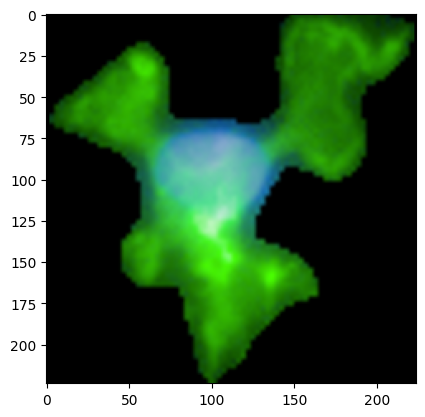

In [4]:
plt.imshow(colourImages[0])

In [5]:
# Load the pre-trained ResNet model
model = VGG16(weights='imagenet')

# Print the names and index of each layer in the model
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten
20 fc1
21 fc2
22 predictions


In [6]:
def computeUAEs(layerName, images):
    intermediateModel = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layerName).output)
    outputs = intermediateModel.predict(images)
    UAEs = np.mean(outputs, axis=(1, 2, 3))
    return UAEs

In [7]:
layerName = 'block4_pool'

In [8]:
uaesBlock4Pool = computeUAEs(layerName, colourImages)

49/49 [==============================] - 331s 7s/step


In [9]:
mean_uae = np.mean(uaesBlock4Pool)
median_uae = np.median(uaesBlock4Pool)
std_uae = np.std(uaesBlock4Pool)
min_uae = np.min(uaesBlock4Pool)
max_uae = np.max(uaesBlock4Pool)

print(f"Mean UAE: {mean_uae}")
print(f"Median UAE: {median_uae}")
print(f"Standard Deviation of UAE: {std_uae}")
print(f"Min UAE: {min_uae}")
print(f"Max UAE: {max_uae}")

Mean UAE: 0.47038283944129944
Median UAE: 0.46873804926872253
Standard Deviation of UAE: 0.05140538886189461
Min UAE: 0.31232213973999023
Max UAE: 0.6485452651977539


c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


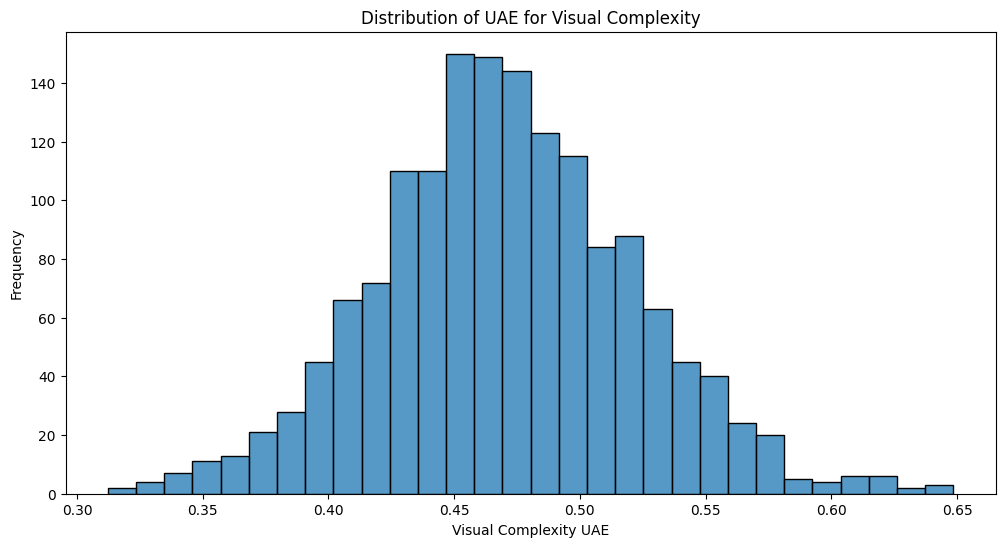

In [10]:
# Distribution
plt.figure(figsize=(12, 6))
sns.histplot(uaesBlock4Pool)
plt.title('Distribution of UAE for Visual Complexity')
plt.xlabel('Visual Complexity UAE')
plt.ylabel('Frequency')
plt.show()

In [16]:
def find_nearest_indices(values, target, n_samples=5):
    """
    Find the indices of n_samples values nearest to the target in the values array.
    """
    indices = np.argsort(np.abs(values - target))[:n_samples]
    return indices

def plot_sampled_images(images, indices, title):
    """
    Plot a subset of pre-loaded PIL images specified by their indices.
    """
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 10))
    fig.suptitle(title)
    if len(indices) == 1:
        axes = [axes]
    for ax, idx in zip(axes, indices):
        img = images[idx]
        ax.imshow(img)
        ax.axis('off')
    plt.show()

def plot_sampled_images_with_uae(images, uae_images, indices, title):
    """
    Plot a subset of pre-loaded PIL images specified by their indices along with their associated UAEs.
    """
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 10))
    fig.suptitle(title)

    if len(indices) == 1:
        axes = [axes]
    for ax, idx in zip(axes, indices):
        img = images[idx]
        complexity = uae_images[idx]
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5, -0.1, f'Complexity: {complexity:.4f}', ha='center', va='top', transform=ax.transAxes, fontsize=8)
    plt.show() 

In [12]:
min_indices = find_nearest_indices(uaesBlock4Pool, np.min(uaesBlock4Pool))
mean_indices = find_nearest_indices(uaesBlock4Pool, np.mean(uaesBlock4Pool))
max_indices = find_nearest_indices(uaesBlock4Pool, np.max(uaesBlock4Pool))

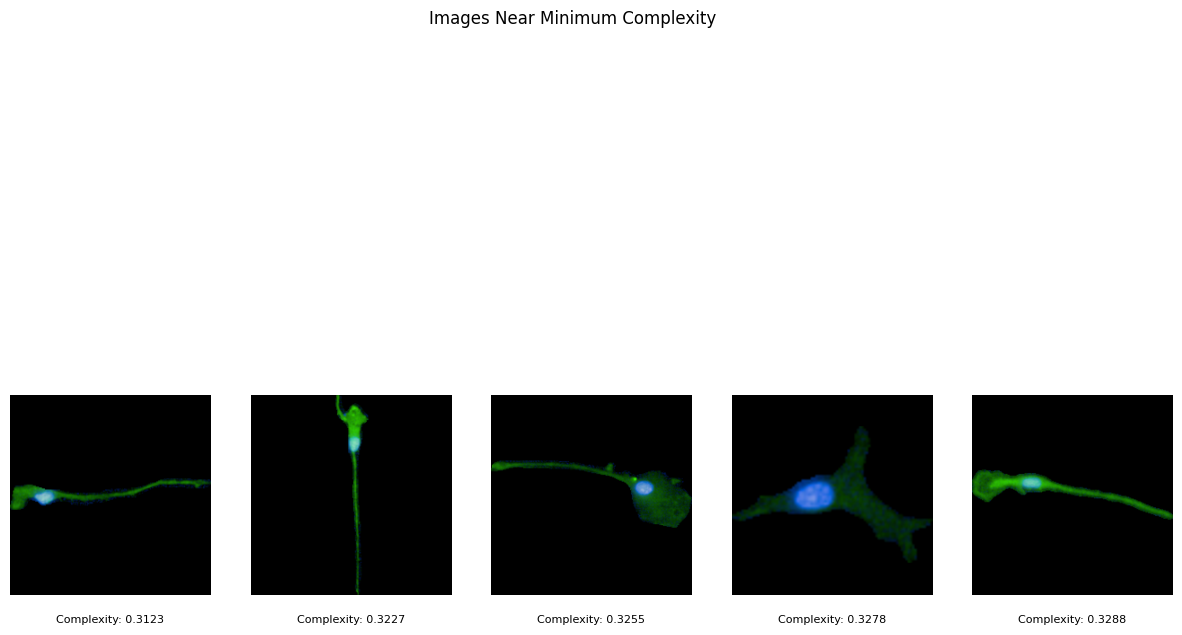

In [17]:
plot_sampled_images_with_uae(colourImages, uaesBlock4Pool, min_indices, "Images Near Minimum Complexity")

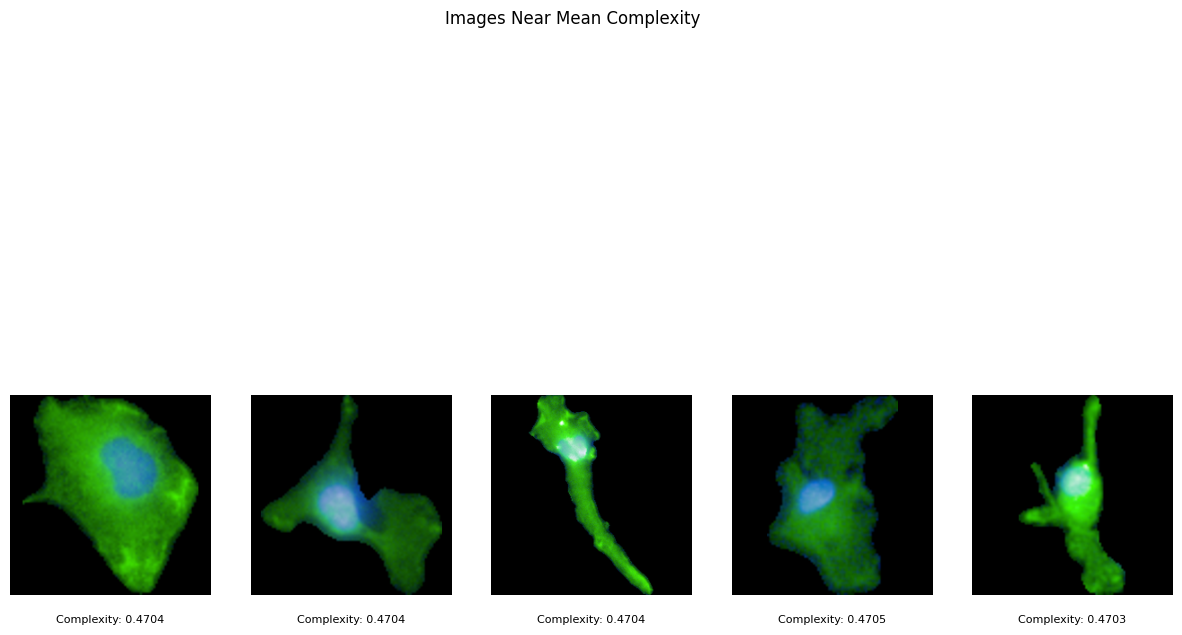

In [18]:
plot_sampled_images_with_uae(colourImages, uaesBlock4Pool, mean_indices, "Images Near Mean Complexity")

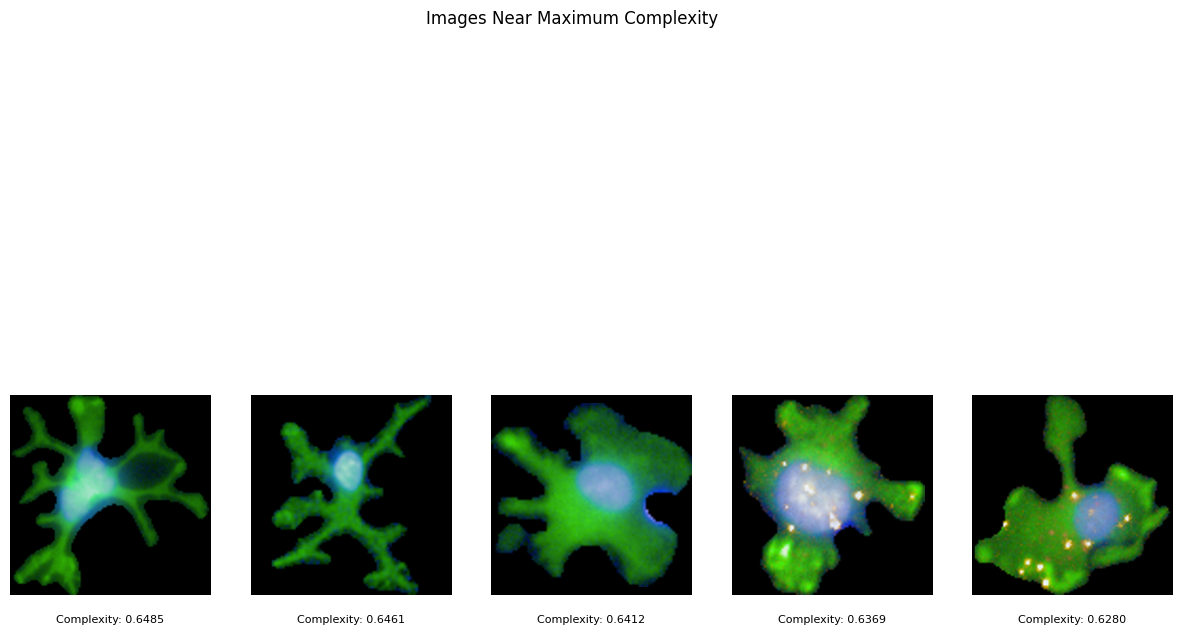

In [19]:
plot_sampled_images_with_uae(colourImages, uaesBlock4Pool, max_indices, "Images Near Maximum Complexity")

10 samples throgh the distribution.

In [22]:
# Ensure data is sorted by complexity
sorted_indices = np.argsort(uaesBlock4Pool)
sorted_images = [colourImages[i] for i in sorted_indices]
sorted_complexities = uaesBlock4Pool[sorted_indices]

In [23]:
# Select 10 samples through the distribution
samples_indices = np.linspace(0, len(sorted_images) - 1, 10, dtype=int)
selected_samples = [sorted_images[i] for i in samples_indices]
selected_complexities = [sorted_complexities[i] for i in samples_indices]

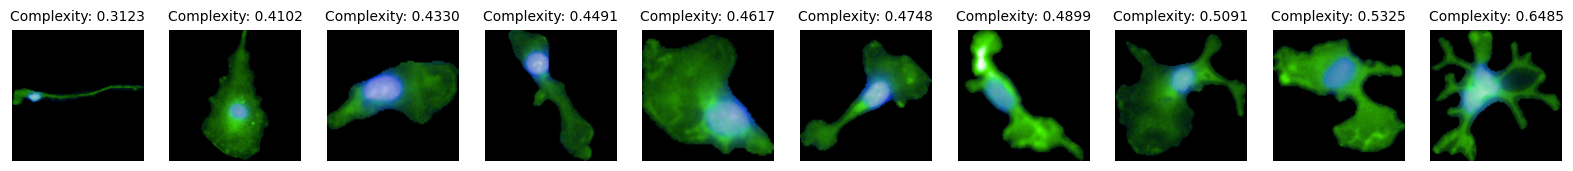

In [24]:
fig, axs = plt.subplots(1, 10, figsize=(20, 4))
for ax, img, comp in zip(axs, selected_samples, selected_complexities):
    ax.imshow(img)
    ax.axis('off')
    ax.text(0.5, 1.05, f'Complexity: {comp:.4f}', ha='center', va='bottom', transform=ax.transAxes, fontsize=10, color='black')

plt.subplots_adjust(bottom=0.15)
plt.show()

Cluster Analysis.

In [ ]:
uaesBlock4Pool.shape

(1560,)

In [ ]:
complexities_reshaped = uaesBlock4Pool.reshape(-1, 1)

In [ ]:
# WCSS sum of square distance between each point and the centroid of the cluster
sse = []  # Sum of squared distances
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(complexities_reshaped)
    sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

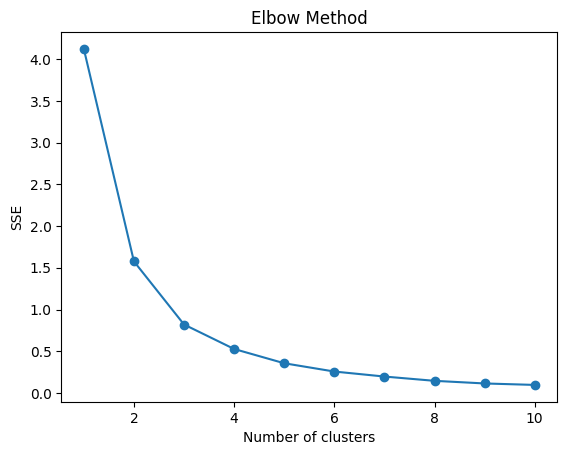

In [ ]:
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [ ]:
k = 4
# Create and fit the K-means model
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(complexities_reshaped)

# Get the cluster assignments for each data point
labels = kmeans.labels_

In [ ]:
labels

array([2, 0, 0, ..., 1, 3, 0])

In [ ]:
cluster_centers = kmeans.cluster_centers_.flatten()

# Find the closest images to each cluster center
closest_images_indices = []
for center in cluster_centers:
    # Calculate the absolute differences between the cluster center and each complexity ratio
    differences = np.abs(complexities_reshaped.flatten() - center)
    # Find the index of the smallest difference for this cluster center
    closest_image_idx = np.argmin(differences)
    closest_images_indices.append(closest_image_idx)

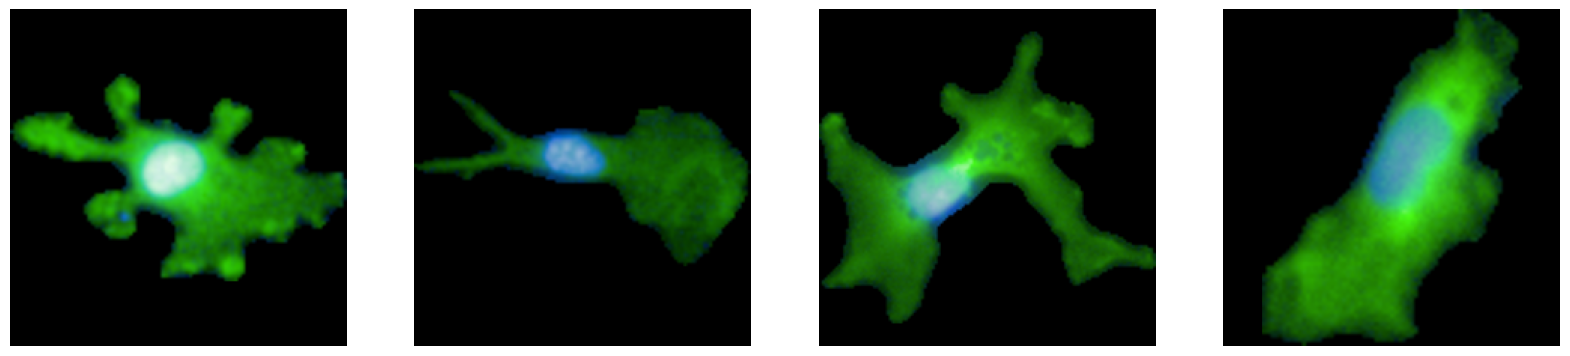

In [ ]:
fig, axes = plt.subplots(1, k, figsize=(20, 10))
for ax, idx in zip(axes, closest_images_indices):
    img = colourImages[idx]
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [ ]:
clustered_images = defaultdict(list)
for label, img in zip(labels, colourImages):
    clustered_images[label].append(img)

In [ ]:
selected_images_random = {}
for cluster, images in clustered_images.items():
    if len(images) >= 5:
        selected_images_random[cluster] = random.sample(images, 5)
    else:
        # If a cluster has fewer than 5 images, take all images
        selected_images_random[cluster] = images

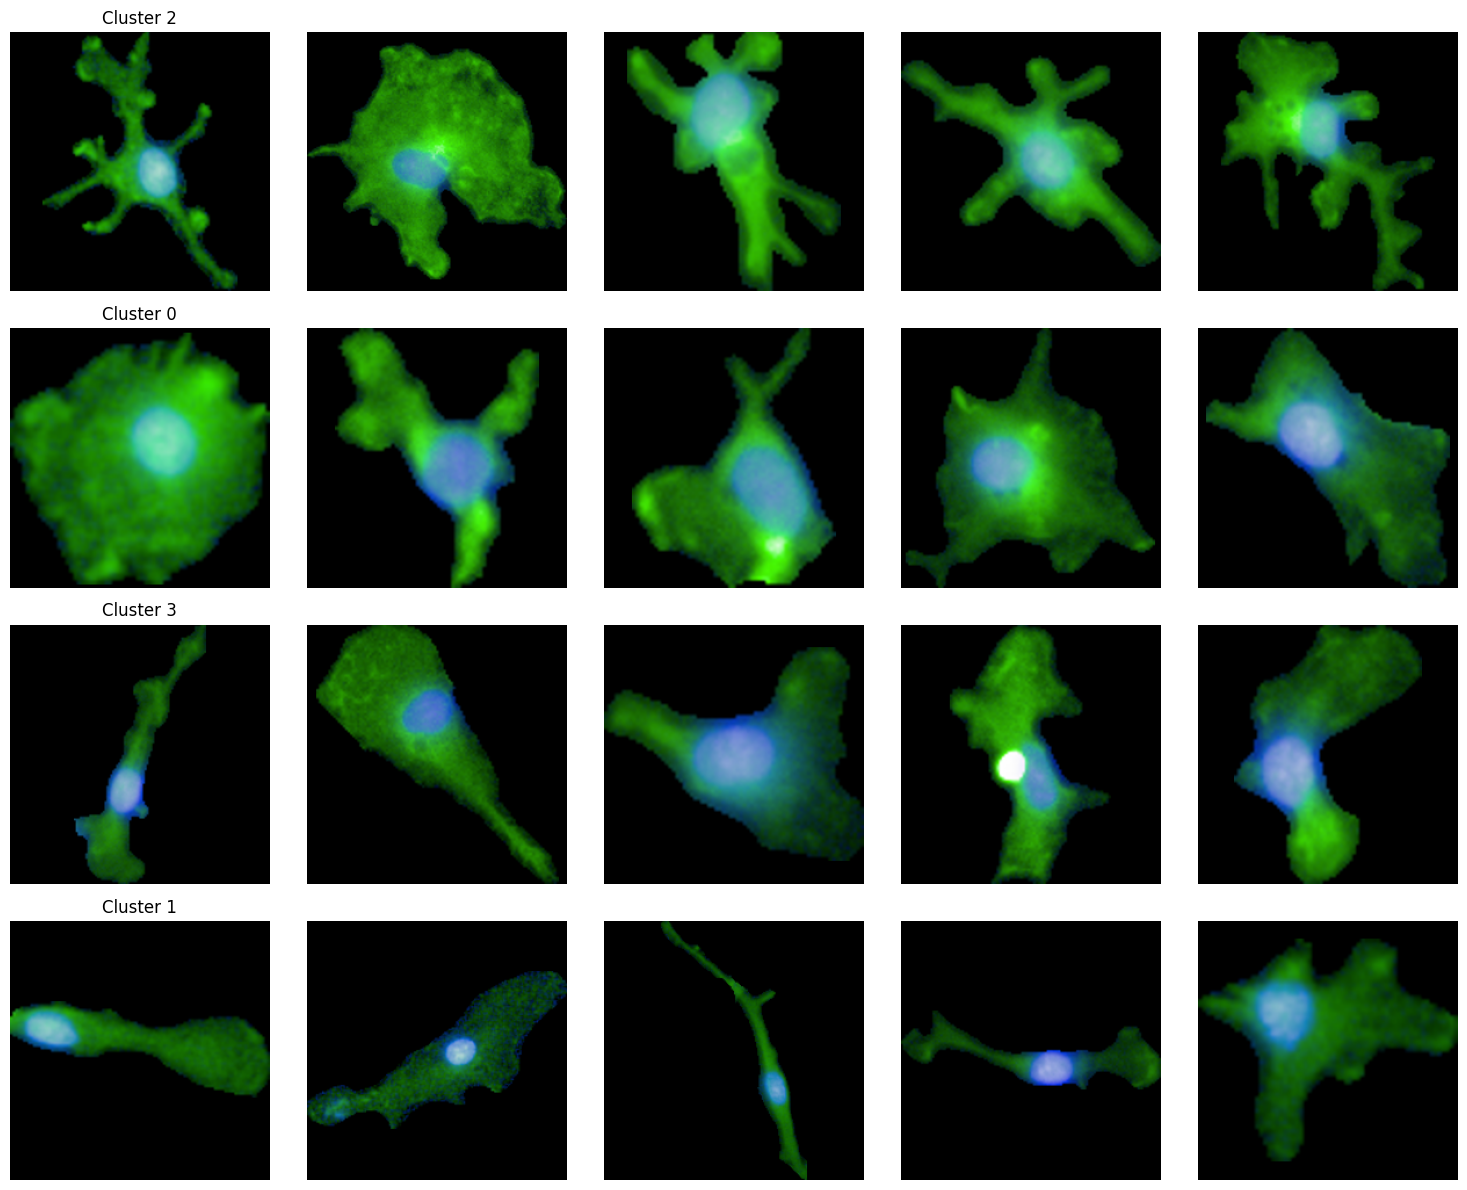

In [ ]:
n_clusters = len(selected_images_random)
fig, axs = plt.subplots(n_clusters, 5, figsize=(15, 3 * n_clusters))

for i, (cluster, images) in enumerate(selected_images_random.items()):
    for j, img in enumerate(images):
        if n_clusters == 1:
            ax = axs[j]
        else:
            ax = axs[i, j]
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'Cluster {cluster}')

plt.tight_layout()
plt.show()